In [1]:
import numpy as np
import qutip as qt
import xarray as xr
from dask.diagnostics import ProgressBar
from simulation_tutorial import xarray_mods as xr_mod

Loosly based on https://nbviewer.org/urls/qutip.org/qutip-tutorials/tutorials-v5/time-evolution/003_qubit-dynamics.ipynb

In [2]:
def ramsey(time_array_s, detuning_hz=0):
    # hamiltonian
    H = detuning_hz * 2 * np.pi * qt.sigmaz() / 2.0
    # initial state
    psi0 = 1/np.sqrt(2)*(qt.basis(2, 0) + qt.basis(2, 1))
    res = qt.mesolve(H, psi0, time_array_s, e_ops=[qt.sigmax()])

    return res.expect[0]


In [12]:
ds = xr.Dataset()
ds['time'] = np.linspace(0, 2e-6, 100)
ds['detuning'] = np.random.normal(0, .5e6, 100)
ds['sx'] = xr_mod.apply_ufunc(
    ramsey, 
    ds.time,
    ds.detuning, 
    input_core_dims=[['time'], []], 
    output_core_dims=[['time']], 
    vectorize=True, 
    # dask='parallelized',
    multiprocessing=True,
    chunksize=10
    )
# with ProgressBar():
#     ds = ds.compute(scheduler='processes')
ds

100%|██████████| 100/100 [00:00<00:00, 699.74it/s]


<xarray.Dataset> Size: 82kB
Dimensions:   (time: 100, detuning: 100)
Coordinates:
  * time      (time) float64 800B 0.0 2.02e-08 4.04e-08 ... 1.98e-06 2e-06
  * detuning  (detuning) float64 800B 7.208e+05 2.359e+05 ... -2.394e+05
Data variables:
    sx        (detuning, time) float64 80kB 1.0 0.9958 0.9833 ... -0.859 -0.8026

In [7]:
args = [ramsey, ds.time, ds.detuning]
kwargs = dict(
    input_core_dims=[['time'], []], 
    output_core_dims=[['time']], 
    vectorize=True)

In [ ]:
args_list = []
print(args, kwargs)

def wrapper_args(*args):
    args_list.append(args)
    return np.nan

kwargs["output_dtypes"] = [float]
xr.apply_ufunc(ramsey, *args[1:], **kwargs)

[<function ramsey at 0x1175acf40>, <xarray.DataArray 'time' (time: 100)> Size: 800B
array([0.000000e+00, 2.020202e-08, 4.040404e-08, 6.060606e-08, 8.080808e-08,
       1.010101e-07, 1.212121e-07, 1.414141e-07, 1.616162e-07, 1.818182e-07,
       2.020202e-07, 2.222222e-07, 2.424242e-07, 2.626263e-07, 2.828283e-07,
       3.030303e-07, 3.232323e-07, 3.434343e-07, 3.636364e-07, 3.838384e-07,
       4.040404e-07, 4.242424e-07, 4.444444e-07, 4.646465e-07, 4.848485e-07,
       5.050505e-07, 5.252525e-07, 5.454545e-07, 5.656566e-07, 5.858586e-07,
       6.060606e-07, 6.262626e-07, 6.464646e-07, 6.666667e-07, 6.868687e-07,
       7.070707e-07, 7.272727e-07, 7.474747e-07, 7.676768e-07, 7.878788e-07,
       8.080808e-07, 8.282828e-07, 8.484848e-07, 8.686869e-07, 8.888889e-07,
       9.090909e-07, 9.292929e-07, 9.494949e-07, 9.696970e-07, 9.898990e-07,
       1.010101e-06, 1.030303e-06, 1.050505e-06, 1.070707e-06, 1.090909e-06,
       1.111111e-06, 1.131313e-06, 1.151515e-06, 1.171717e-06, 1.1919

SyntaxError: 'return' outside function (2614046351.py, line 10)

In [ ]:
xr.DataArray(ds.detuning).chunk(10)

<xarray.DataArray 'detuning' (detuning: 10000)> Size: 80kB
dask.array<xarray-<this-array>, shape=(10000,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * detuning  (detuning) float64 80kB -5.66e+05 -5.464e+05 ... 4.688e+05

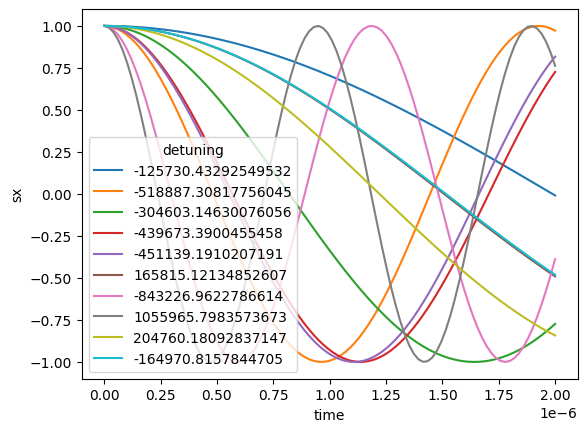

In [36]:
ds.isel(detuning=slice(0,10)).sx.plot(hue='detuning');

In [34]:
ds

<xarray.Dataset> Size: 8MB
Dimensions:   (time: 100, detuning: 10000)
Coordinates:
  * time      (time) float64 800B 0.0 2.02e-08 4.04e-08 ... 1.98e-06 2e-06
  * detuning  (detuning) float64 80kB -9.291e+05 -2.828e+05 ... -1.192e+05
Data variables:
    res       (detuning) object 80kB dask.array<chunksize=(100,), meta=np.ndarray>
    sx        (detuning, time) float64 8MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    sx_exp    (time) float64 800B dask.array<chunksize=(100,), meta=np.ndarray>

In [37]:
ds['sx_exp'] = ds.sx.mean("detuning")

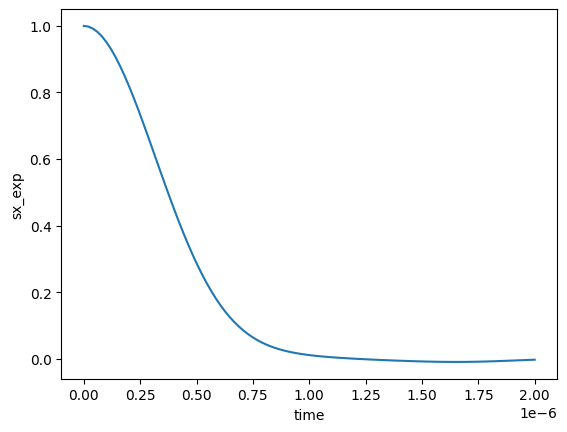

In [38]:
ds.sx_exp.plot()